![HELP-Logo](https://avatars1.githubusercontent.com/u/7880370?s=200&v=4)


# DMU 24 - GAMA-09: Photo-z Selection Function

The goal is to create a selection function for the photometric redshifts that varies spatially across the field. We will use the depth maps for the optical masterlist to find regions of the field that have similar photometric coverage and then calculate the fraction of sources meeting a given photo-z selection within those pixels.

1. For optical depth maps: do clustering analysis to find HEALpix with similar photometric properties.
2. Calculate selection function within those groups of similar regions as a function of magnitude in a given band.
3. Paramatrise the selection function in such a way that it can be easily applied for a given sample of sources or region.

In [66]:
import datetime
print("This notebook was executed on: \n{}".format(datetime.datetime.now()))

This notebook was executed on: 
2018-06-28 13:50:11.453022


In [67]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

import os
import time

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table, join
import numpy as np
import healpy as hp

import warnings
#We ignore warnings - this is a little dangerous but a huge number of warnings are generated by empty cells later
warnings.filterwarnings('ignore')

from astropy.io.votable import parse_single_table
from astropy.io import fits
from astropy.stats import binom_conf_interval
from astropy.utils.console import ProgressBar
from astropy.modeling.fitting import LevMarLSQFitter

from sklearn.cluster import MiniBatchKMeans, MeanShift
from collections import Counter

from astropy.modeling import Fittable1DModel, Parameter

In [68]:
def coords_to_hpidx(ra, dec, order):
    """Convert coordinates to HEALPix indexes
    Given to list of right ascension and declination, this function computes
    the HEALPix index (in nested scheme) at each position, at the given order.
    Parameters
    ----------
    ra: array or list of floats
        The right ascensions of the sources.
    dec: array or list of floats
        The declinations of the sources.
    order: int
        HEALPix order.
    Returns
    -------
    array of int
        The HEALPix index at each position.
    """
    ra, dec = np.array(ra), np.array(dec)

    theta = 0.5 * np.pi - np.radians(dec)
    phi = np.radians(ra)
    healpix_idx = hp.ang2pix(2**order, theta, phi, nest=True)

    return healpix_idx

class GLF1D(Fittable1DModel):
    """
    Generalised Logistic Function 
    """
    inputs = ('x',)
    outputs = ('y',)

    A = Parameter()
    B = Parameter()
    K = Parameter()
    Q = Parameter()
    nu = Parameter()
    M = Parameter()
    
    @staticmethod
    def evaluate(x, A, B, K, Q, nu, M):
        top = K - A
        bottom = (1 + Q*np.exp(-B*(x-M)))**(1/nu)
        return A + (top/bottom)

    @staticmethod
    def fit_deriv(x, A, B, K, Q, nu, M):
        d_A = 1 - (1 + (Q*np.exp(-B*(x-M)))**(-1/nu))
        
        d_B = ((K - A) * (x-M) * (Q*np.exp(-B*(x-M)))) / (nu * ((1 + Q*np.exp(-B*(x-M)))**((1/nu) + 1)))

        d_K = 1 + (Q*np.exp(-B*(x-M)))**(-1/nu)
        
        d_Q = -((K - A) * (Q*np.exp(-B*(x-M)))) / (nu * ((1 + Q*np.exp(-B*(x-M)))**((1/nu) + 1)))
        
        d_nu = ((K-A) * np.log(1 + (Q*np.exp(-B*(x-M))))) / ((nu**2) * ((1 + Q*np.exp(-B*(x-M)))**((1/nu))))
        
        d_M = -((K - A) * (Q*B*np.exp(-B*(x-M)))) / (nu * ((1 + Q*np.exp(-B*(x-M)))**((1/nu) + 1)))

        return [d_A, d_B, d_K, d_Q, d_nu, d_M]
    
class InverseGLF1D(Fittable1DModel):
    """
    Generalised Logistic Function 
    """
    inputs = ('x',)
    outputs = ('y',)

    A = Parameter()
    B = Parameter()
    K = Parameter()
    Q = Parameter()
    nu = Parameter()
    M = Parameter()
    
    @staticmethod
    def evaluate(x, A, B, K, Q, nu, M):
        return M - (1/B)*(np.log((((K - A)/(x -A))**nu - 1)/Q))
    

## 0 - Set relevant initial parameters

In [69]:
FIELD = 'GAMA-09'
ORDER = 10

DEPTH_MAP = '../../dmu1/dmu1_ml_GAMA-09/data/depths_gama-09_20180601.fits'
MASTERLIST = '../../dmu1/dmu1_ml_GAMA-09/data/master_catalogue_gama-09_20171206.fits'
PHOTOZS = 'data/master_catalogue_gama-09_20171206_photoz_20180213_r_optimised.fits'

OUT_DIR = 'data'
SUFFIX = 'depths_20171016_photoz_20180213'



## I - Find clustering of healpix in the depth maps

In [70]:
depth_map = Table.read(DEPTH_MAP)

# Get Healpix IDs
hp_idx = depth_map['hp_idx_O_{0}'.format(ORDER)]

# Calculate RA, Dec of depth map Healpix pixels for later plotting etc.
dm_hp_ra, dm_hp_dec = hp.pix2ang(2**ORDER, hp_idx, nest=True, lonlat=True)

The depth map provides two measures of depth:

In [71]:
mean_values = Table(depth_map.columns[2::2]) # Mean 1-sigma error within a cell
p90_values = Table(depth_map.columns[3::2]) # 90th percentile of observed fluxes

For the photo-z selection functions we will make use of the mean 1-sigma error as this can be used to accurately predict the completeness as a function of magnitude.

We convert the mean 1-sigma uncertainty to a 3-sigma magnitude upper limit and convert to a useable array.
When a given flux has no measurement in a healpix (and *ferr_mean* is therefore a *NaN*) we set the depth to some semi-arbitrary bright limit separate from the observed depths:

In [72]:
dm_clustering = 23.9 - 2.5*np.log10(3*mean_values.to_pandas().as_matrix())
dm_clustering[np.isnan(dm_clustering)] = 14
dm_clustering[np.isinf(dm_clustering)] = 14


To encourage the clustering to group nearby Healpix together, we also add the RA and Dec of the healpix to the inpux dataset:

In [73]:
dm_clustering = np.hstack([dm_clustering, np.array(dm_hp_ra.data, ndmin=2).T, np.array(dm_hp_dec.data, ndmin=2).T])

Next, we find clusters within the depth maps using a simple k-means clustering. For the number of clusters we assume an initial guess on the order of the number of different input magnitdues (/depths) in the dataset. This produces good initial results but may need further tuning:

In [74]:
NCLUSTERS = dm_clustering.shape[1]*2
km = MiniBatchKMeans(n_clusters=NCLUSTERS)

km.fit(dm_clustering)

counts = Counter(km.labels_) # Quickly calculate sizes of the clusters for reference

clusters = dict(zip(hp_idx.data, km.labels_))

Below we illustrate the different clusters with each colour corresponding to a different group of similar sources (although the colours may not be unique to a single cluster of sources). You can see structures and patterns within the field, e.g. the outline of the HSC coverage.

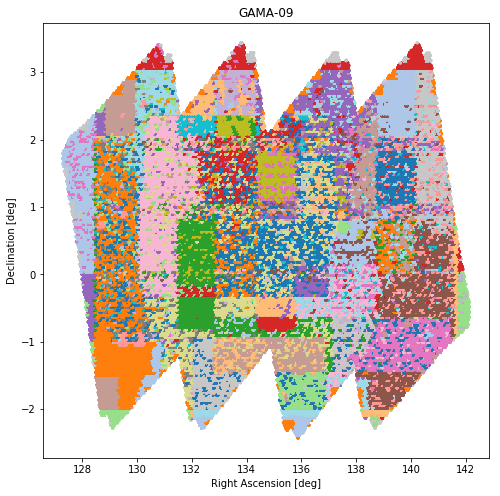

In [75]:
Fig, Ax = plt.subplots(1,1,figsize=(8,8))
Ax.scatter(dm_hp_ra, dm_hp_dec, c=km.labels_, cmap=plt.cm.tab20, s=6)

Ax.set_xlabel('Right Ascension [deg]')
Ax.set_ylabel('Declination [deg]')
Ax.set_title('{0}'.format(FIELD))
Fig.savefig('plots/dmu24_{0}_sf_hpclusters_illustration.png'.format(FIELD), 
            format='png', bbox_inches='tight', dpi=150)

## II - Map photo-z and masterlist objects to their corresponding depth cluster


We now load the photometric redshift catalog and keep only the key columns for this selection function.
Note: if using a different photo-$z$ measure than the HELP standard `z1_median`, the relevant columns should be retained instead.

In [76]:
photoz_catalogue = Table.read(PHOTOZS)

photoz_catalogue.keep_columns(['help_id', 'RA', 'DEC', 'id', 'z1_median', 'z1_min', 'z1_max', 'z1_area'])

Next we load the relevant sections of the masterlist catalog (including the magnitude columns) and map the Healpix values to their corresponding cluster. For each of the masterlist/photo-$z$ sources and their corresponding healpix we find the respective cluster.

In [77]:
masterlist_hdu = fits.open(MASTERLIST, memmap=True)
masterlist = masterlist_hdu[1]

masterlist_catalogue = Table()
masterlist_catalogue['help_id'] = masterlist.data['help_id']
masterlist_catalogue['RA'] = masterlist.data['ra']
masterlist_catalogue['DEC'] = masterlist.data['dec']

for column in masterlist.columns.names:
    if (column.startswith('m_') or column.startswith('merr_')):
        masterlist_catalogue[column] = masterlist.data[column]

masterlist_hpx = coords_to_hpidx(masterlist_catalogue['RA'], masterlist_catalogue['DEC'], ORDER)

keys = np.array([*clusters])
incl = np.array([hpx in clusters.keys() for hpx in masterlist_hpx])
if incl.sum() != len(incl):
    notincl = np.where(np.invert(incl))[0]
    for i in notincl:
        masterlist_hpx[i] = keys[np.argmin(np.abs(masterlist_hpx[i] -keys))]
    
masterlist_catalogue["hp_idx_O_{:d}".format(ORDER)] = masterlist_hpx

In [78]:
masterlist_cl_no = np.array([clusters[hpx] for hpx in masterlist_hpx])
masterlist_catalogue['hp_depth_cluster'] = masterlist_cl_no

In [79]:
merged = join(masterlist_catalogue, photoz_catalogue, join_type='left', keys=['help_id', 'RA', 'DEC'])

### Constructing the output selection function table:

The photo-$z$ selection function will be saved in a table that mirrors the format of the input optical depth maps, with matching length.

In [80]:
pz_depth_map = Table()
pz_depth_map.add_column(depth_map['hp_idx_O_13'])
pz_depth_map.add_column(depth_map['hp_idx_O_10'])

## III - Creating the binary photo-z selection function

With the sources now easily grouped into regions of similar photometric properties, we can calculate the photo-$z$ selection function within each cluster of pixels. To begin with we want to create the most basic set of photo-$z$ selection functions - a map of the fraction of sources in the masterlist in a given region that have a photo-$z$ estimate. We will then create more informative selection function maps that make use of the added information from clustering.

In [81]:
NCLUSTERS # Fixed during the clustering stage above

128

In [82]:
cluster_photoz_fraction = np.ones(NCLUSTERS)

pz_frac_cat = np.zeros(len(merged))
pz_frac_map = np.zeros(len(dm_hp_ra))

for ic, cluster in enumerate(np.arange(NCLUSTERS)):
    ml_sources = (merged['hp_depth_cluster'] == cluster)
    has_photoz = (merged['z1_median'] > -90.)
    
    in_ml = np.float(ml_sources.sum())
    withz = np.float((ml_sources*has_photoz).sum())
    
    if in_ml > 0:
        frac = withz / in_ml 
    else:
        frac = 0.
    
    cluster_photoz_fraction[ic] = frac
    print("""{0} In cluster: {1:<6.0f} With photo-z: {2:<6.0f}\
    Fraction: {3:<6.3f}""".format(cluster, in_ml, withz, frac))
    
    # Map fraction to catalog positions for reference
    where_cat = (merged['hp_depth_cluster'] == cluster)
    pz_frac_cat[where_cat] = frac
    
    # Map fraction back to depth map healpix 
    where_map = (km.labels_ == cluster)
    pz_frac_map[where_map] = frac

0 In cluster: 442335 With photo-z: 401967    Fraction: 0.909 
1 In cluster: 609557 With photo-z: 561748    Fraction: 0.922 
2 In cluster: 118048 With photo-z: 68295     Fraction: 0.579 
3 In cluster: 129046 With photo-z: 74736     Fraction: 0.579 
4 In cluster: 141322 With photo-z: 74439     Fraction: 0.527 
5 In cluster: 108983 With photo-z: 81815     Fraction: 0.751 
6 In cluster: 92184  With photo-z: 40311     Fraction: 0.437 
7 In cluster: 67982  With photo-z: 32363     Fraction: 0.476 
8 In cluster: 215677 With photo-z: 109506    Fraction: 0.508 
9 In cluster: 95669  With photo-z: 34631     Fraction: 0.362 
10 In cluster: 50687  With photo-z: 35461     Fraction: 0.700 
11 In cluster: 30016  With photo-z: 11738     Fraction: 0.391 
12 In cluster: 11295  With photo-z: 4651      Fraction: 0.412 
13 In cluster: 12591  With photo-z: 8680      Fraction: 0.689 
14 In cluster: 241443 With photo-z: 212470    Fraction: 0.880 
15 In cluster: 47362  With photo-z: 25701     Fraction: 0.543 
16

### The binary photo-$z$ selection function of the field

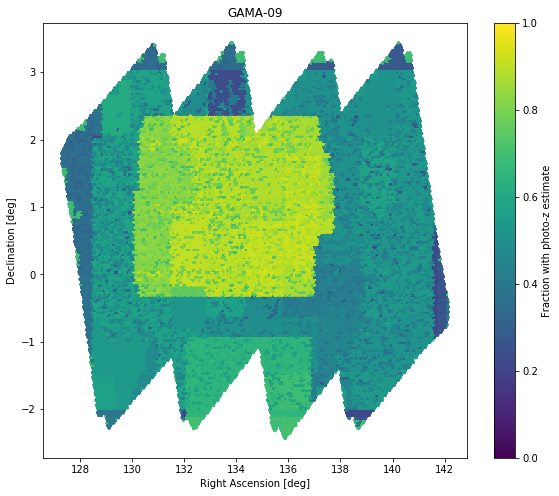

In [83]:
Fig, Ax = plt.subplots(1,1,figsize=(9.5,8))
Sc = Ax.scatter(dm_hp_ra, dm_hp_dec, c=pz_frac_map, cmap=plt.cm.viridis, s=6, vmin=0, vmax=1)

Ax.set_xlabel('Right Ascension [deg]')
Ax.set_ylabel('Declination [deg]')
Ax.set_title('{0}'.format(FIELD))
CB = Fig.colorbar(Sc)
CB.set_label('Fraction with photo-z estimate')
Fig.savefig('plots/dmu24_{0}_sf_binary_map.png'.format(FIELD), 
            format='png', bbox_inches='tight', dpi=150)

### Add the binary photo-$z$ selection function to output catalog

In [84]:
pz_depth_map.add_column(Column(name='pz_fraction', data=pz_frac_map))

## IV - Magnitude dependent photo-z selection functions

The binary selection function gives a broad illustration of where photo-$z$s are available in the field (given the availability of optical datasets etc.). However, the fraction of sources that have an estimate available will depend on the brightness of a given source in the bands used for photo-$z$s.
Furthermore, the quality of those photo-$z$ is also highly dependent on the depth, wavelength coverage and sampling of the optical data in that region.

To calculate the likelihood of a given source having a photo-$z$ that passes the defined quality selection or be able to select samples of homogeneous photo-$z$ quality, we therefore need to estimate the magnitude (and spatially) dependent selection function.

### Defining the photo-$z$ quality criteria

A key stage in the photo-$z$ estimation methodology is the explicit calibration of the redshift posteriors as a function of magnitude. The benefit of this approach is that by making a cut based on the width of redshift posterior, $P(z)$, we can select sources with a desired estimated redshift precision.
Making this cut based on the full $P(z)$ is impractical. However the main photo-$z$ catalog contains information about the width of the primary and secondary peaks above the 80% highest probability density (HPD) credible interval, we can use this information to determine our redshift quality criteria.

Parse columns to select the available magnitudes within the masterlist:

In [85]:
filters = [col for col in merged.colnames if col.startswith('m_')]
print('{0} magnitude columns present in the masterlist.'.format(len(filters)))

62 magnitude columns present in the masterlist.


In [86]:
scaled_photoz_error = (0.5*(merged['z1_max']- merged['z1_min'])) / (1 + merged['z1_median'])

photoz_quality_cut = (scaled_photoz_error < 0.2)


To calculate the magnitude dependent selection function in a given masterlist filter, for each of the Healpix clusters we do the following:
1. Find the number of masterlist sources within that cluster that have a measurement in the corresponding filter. (If this is zero - see stage 3B)
2. Calculate the fraction of sources at that magnitude that haThis relation typically follows a form of a sigmoid function the declines towards fainter magnitudes - however depending on the selection being applied it may not start at 1. Similarly, the rate of decline and the turnover point depends on the depth of the optical selection properties of that cluster.
3. 
    1. Fit the magnitude dependence using the generalised logistic function (GLF, or Richards' function). Provided with conservative boundary conditions and plausible starting conditions based on easily estimated properties (i.e. the typical magnitude in the cluster and the maximum point), this function is able to describe well almost the full range of measured selection functions.
    2. If no masterlist sources in the cluster have an observation in the filter - all parameters set to zero (with the GLF then returning zero for all magnitudes).
4. Map the parameters estimated for a given healpix cluster back to the healpix belonging to that cluster.

In [87]:
for photometry_band in filters:
    print(photometry_band)
    
    pz_frac_cat = np.zeros(len(merged))
    pz_M_map = np.zeros((len(dm_hp_ra),6))

    if np.isnan(merged[photometry_band]).sum() < len(merged):
        m001, m999 = np.nanpercentile(merged[photometry_band], [0.1, 99.9])


        counts, binedges = np.histogram(merged[photometry_band], 
                                        range=(np.minimum(m001, 17.), np.minimum(m999, 29.)),
                                       bins=10)

        binmids = 0.5*(binedges[:-1] + binedges[1:])


        with ProgressBar(NCLUSTERS, ipython_widget=True) as bar:
            for ic, cluster in enumerate(np.arange(NCLUSTERS)[:]):
                ml_sources = (merged['hp_depth_cluster'] == cluster)
                has_photoz = (merged['z1_median'] > -90.) * photoz_quality_cut
                has_mag = (merged[photometry_band] > -90.)

                in_ml = np.float(ml_sources.sum())
                withz = (has_photoz)

                frac = []
                frac_upper = []
                frac_lower = []

                iqr25_mag = (np.nanpercentile(merged[photometry_band][ml_sources*has_photoz], 25))

                if (ml_sources*has_photoz*has_mag).sum() > 1:
                    for i in np.arange(len(binedges[:-1])):
                        mag_cut = np.logical_and(merged[photometry_band] >= binedges[i],
                                                 merged[photometry_band] < binedges[i+1])

                        if (ml_sources * mag_cut).sum() > 0:
                            pass_cut = np.sum(ml_sources * withz * mag_cut)
                            total_cut = np.sum(ml_sources * mag_cut)
                            frac.append(np.float(pass_cut) / total_cut)

                            lower, upper = binom_conf_interval(pass_cut, total_cut)
                            frac_lower.append(lower)
                            frac_upper.append(upper)

                        else:
                            frac.append(0.)
                            frac_lower.append(0.)
                            frac_upper.append(1.)

                    frac = np.array(frac)
                    frac_upper = np.array(frac_upper)
                    frac_lower = np.array(frac_lower)


                    model = GLF1D(A=np.median(frac[:5]), K=0., B=0.9, Q=1., nu=0.4, M=iqr25_mag, 
                                  bounds={'A': (0,1), 'K': (0,1), 'B': (0., 5.),
                                          'M': (np.minimum(m001, 17.), np.minimum(m999, 29.)),
                                          'Q': (0., 10.),
                                          'nu': (0, None)})

                    fit = LevMarLSQFitter()
                    m = fit(model, x=binmids, y=frac, maxiter=1000,
                            weights=1/(0.5*((frac_upper-frac) + (frac-frac_lower))), 
                            estimate_jacobian=False)
                    parameters = np.copy(m.parameters)

                else:
                    frac = np.zeros(len(binmids))
                    frac_upper = np.zeros(len(binmids))
                    frac_lower = np.zeros(len(binmids))

                    parameters = np.zeros(6)

                # Map parameters to cluster

                # Map parameters back to depth map healpix 
                where_map = (km.labels_ == cluster)
                pz_M_map[where_map] = parameters

                bar.update()
        
        
    else:
        pz_M_map = [np.zeros(6)] * len(dm_hp_ra)
        
    c = Column(data=pz_M_map, name='pz_glf_{0}'.format(photometry_band), shape=(1,6))

    try:
        pz_depth_map.add_column(c)
    except:
        pz_depth_map.replace_column('pz_glf_{0}'.format(photometry_band), c)

m_ap_megacam_u


FloatProgress(value=0.0)


m_megacam_u


FloatProgress(value=0.0)


m_ap_megacam_g


FloatProgress(value=0.0)


m_megacam_g


FloatProgress(value=0.0)


m_ap_megacam_r


FloatProgress(value=0.0)


m_megacam_r


FloatProgress(value=0.0)


m_ap_megacam_i


FloatProgress(value=0.0)


m_megacam_i


FloatProgress(value=0.0)


m_ap_megacam_z


FloatProgress(value=0.0)


m_megacam_z


FloatProgress(value=0.0)


m_ap_decam_g


FloatProgress(value=0.0)


m_decam_g


FloatProgress(value=0.0)


m_ap_decam_r


FloatProgress(value=0.0)


m_decam_r


FloatProgress(value=0.0)


m_ap_decam_z


FloatProgress(value=0.0)


m_decam_z


FloatProgress(value=0.0)


m_ap_suprime_g


FloatProgress(value=0.0)


m_suprime_g


FloatProgress(value=0.0)


m_ap_suprime_r


FloatProgress(value=0.0)


m_suprime_r


FloatProgress(value=0.0)


m_ap_suprime_i


FloatProgress(value=0.0)


m_suprime_i


FloatProgress(value=0.0)


m_ap_suprime_z


FloatProgress(value=0.0)


m_suprime_z


FloatProgress(value=0.0)


m_ap_suprime_y


FloatProgress(value=0.0)


m_suprime_y


FloatProgress(value=0.0)


m_ap_omegacam_u


FloatProgress(value=0.0)


m_omegacam_u


FloatProgress(value=0.0)


m_ap_omegacam_g


FloatProgress(value=0.0)


m_omegacam_g


FloatProgress(value=0.0)


m_ap_omegacam_r


FloatProgress(value=0.0)


m_omegacam_r


FloatProgress(value=0.0)


m_ap_omegacam_i


FloatProgress(value=0.0)


m_omegacam_i


FloatProgress(value=0.0)


m_ap_gpc1_g


FloatProgress(value=0.0)


m_gpc1_g


FloatProgress(value=0.0)


m_ap_gpc1_r


FloatProgress(value=0.0)


m_gpc1_r


FloatProgress(value=0.0)


m_ap_gpc1_i


FloatProgress(value=0.0)


m_gpc1_i


FloatProgress(value=0.0)


m_ap_gpc1_z


FloatProgress(value=0.0)


m_gpc1_z


FloatProgress(value=0.0)


m_ap_gpc1_y


FloatProgress(value=0.0)


m_gpc1_y


FloatProgress(value=0.0)


m_ap_ukidss_y


FloatProgress(value=0.0)


m_ukidss_y


FloatProgress(value=0.0)


m_ap_ukidss_j


FloatProgress(value=0.0)


m_ukidss_j


FloatProgress(value=0.0)


m_ap_ukidss_h


FloatProgress(value=0.0)


m_ukidss_h


FloatProgress(value=0.0)


m_ap_ukidss_k


FloatProgress(value=0.0)


m_ukidss_k


FloatProgress(value=0.0)


m_ap_vista_z


FloatProgress(value=0.0)


m_vista_z


FloatProgress(value=0.0)


m_ap_vista_y


FloatProgress(value=0.0)


m_vista_y


FloatProgress(value=0.0)


m_ap_vista_j


FloatProgress(value=0.0)


m_vista_j


FloatProgress(value=0.0)


m_ap_vista_h


FloatProgress(value=0.0)


m_vista_h


FloatProgress(value=0.0)


m_ap_vista_ks


FloatProgress(value=0.0)


m_vista_ks


FloatProgress(value=0.0)

The selection function catalog consists of a set of parameters for the generalised logistic function (GLF, or Richards' function) that can be used to calculate the fraction of masterlist sources that have a photo-$z$ estimate satisfying the quality cut as a function of a given magnitude. e.g.

$S = \rm{GLF}(M_{f}, \textbf{P}_{\rm{Healpix}})$,

where $S$ is the success fraction for a given magnitude $M_{f}$ in a given filter, $f$, and $\textbf{P}_{\rm{Healpix}}$ corresponds to the set of 6 parameters fit for that healpix.


In practical terms, using the GLF function defined in this notebook this would be `S = GLF1D(*P)(M)`. Similarly, to estimate the magnitude corresponding to a desired photo-$z$ completeness one can use the same parameters and the corresponding inverse function: `M = InverseGLF1D(*P)(S)`.

### Save the photo-$z$ selection function catalog:

In [88]:
pz_depth_map.write('{0}/photo-z_selection_{1}_{2}.fits'.format(OUT_DIR, FIELD, SUFFIX).lower(), format='fits', overwrite=True)


 ![HELP LOGO](https://avatars1.githubusercontent.com/u/7880370?s=75&v=4)
 
**Author**: [Kenneth Duncan](http://dunkenj.github.io)

The Herschel Extragalactic Legacy Project, ([HELP](http://herschel.sussex.ac.uk/)), is a [European Commission Research Executive Agency](https://ec.europa.eu/info/departments/research-executive-agency_en)
funded project under the SP1-Cooperation, Collaborative project, Small or medium-scale focused research project, FP7-SPACE-2013-1 scheme, Grant Agreement
Number 607254.

[Acknowledgements](http://herschel.sussex.ac.uk/acknowledgements)

